In this notebook, a simple MLP will try to match a wavefield snapshot generated with Salvus for a simple homogeneous case with the parameters taken from the Moseley paper.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import h5py

In [2]:
# Pytorch Model Name
model_name = 'Moseley_Min_Max.pt'

# Load Salvus data
path = "../NoCrack/Simple_Homogeneous_Moseley/Event0000/output.h5"
hf = h5py.File(path, 'r')

In [3]:
df_start = pd.DataFrame()
df_start['X'] = hf['coordinates_ACOUSTIC'][:,0][:,0].astype(float)
df_start['Y'] = hf['coordinates_ACOUSTIC'][:,0][:,1].astype(float)
df_start['True'] = hf['volume']['phi'][50][:,0].mean(axis=1)

In [4]:
# Scaling, optional
from sklearn.preprocessing import MinMaxScaler

scaling = True
if scaling:
    scaler = MinMaxScaler()
    df_start[['X','Y','True']] = scaler.fit_transform(df_start[['X','Y','True']])

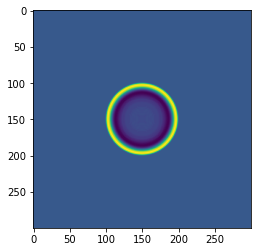

In [5]:
# Pivot Table to reorder the data
df_show = df_start.pivot_table(values='True',index='Y',columns='X').sort_index(axis=0,ascending=False)

# Plot
plt.imshow(df_show.values)

<AxesSubplot:>

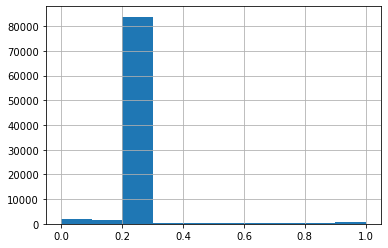

In [6]:
df_start['True'].hist()

In [7]:
import torch
import torch.nn as nn

from model import *

In [8]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [9]:
def train(model,X_train,y_train,loss_fn,optimizer,epoch):
    model = model.to(device)

    x = torch.tensor(X_train[:, 0:1], requires_grad=True).float().to(device)
    y = torch.tensor(X_train[:, 1:2], requires_grad=True).float().to(device)

    true = torch.tensor(y_train).float().to(device)

    tot_loss = []
    for i in range(epoch):
        model.train()

        optimizer.zero_grad()

        preds = model(torch.cat([x, y], dim=1))

        loss = loss_fn(preds,true)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print('Iter %d, Loss: %.5e' % (i,loss))

        tot_loss.append(loss)

    model.eval()

    preds = model(torch.cat([x, y], dim=1))
    preds = preds.detach().cpu().numpy()

    return model, preds, tot_loss

In [10]:
def plots(df_data):
    # Compute error :
    df_data['Error'] = df_data['Preds']-df_data['True']

    # Plot :
    fig, ax = plt.subplots(1,3,figsize=(16,4))

    im = ax[0].imshow(df_data.pivot_table(values='Preds',index='Y',columns='X').sort_index(axis=0,ascending=False))
    ax[0].set_title('Prediction')
    fig.colorbar(im, ax=ax[0])

    im = ax[1].imshow(df_data.pivot_table(values='True',index='Y',columns='X').sort_index(axis=0,ascending=False))
    ax[1].set_title('True')
    fig.colorbar(im, ax=ax[1])

    im = ax[2].imshow(df_data.pivot_table(values='Error',index='Y',columns='X').sort_index(axis=0,ascending=False))
    ax[2].set_title('Error')
    fig.colorbar(im, ax=ax[2])

    plt.show()

In [11]:
model = Model(in_size=2)

loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

X_train = df_start.loc[:,['X','Y']].values
y_train = df_start.loc[:,['True']].values

In [12]:
epoch = 10000
model_trained_start, preds_start, loss_start = train(model,X_train,y_train,loss_fn,optimizer,epoch)

Iter 0, Loss: 1.70664e-01
Iter 100, Loss: 9.19835e-03
Iter 200, Loss: 9.19452e-03
Iter 300, Loss: 9.19363e-03
Iter 400, Loss: 9.19295e-03
Iter 500, Loss: 9.19245e-03
Iter 600, Loss: 9.19207e-03
Iter 700, Loss: 9.19180e-03
Iter 800, Loss: 9.19158e-03
Iter 900, Loss: 9.19141e-03
Iter 1000, Loss: 9.19129e-03
Iter 1100, Loss: 9.19119e-03
Iter 1200, Loss: 9.19111e-03
Iter 1300, Loss: 9.19105e-03
Iter 1400, Loss: 9.19099e-03
Iter 1500, Loss: 9.19095e-03
Iter 1600, Loss: 9.19091e-03
Iter 1700, Loss: 9.19087e-03
Iter 1800, Loss: 9.19084e-03
Iter 1900, Loss: 9.19080e-03
Iter 2000, Loss: 9.19076e-03
Iter 2100, Loss: 9.19073e-03
Iter 2200, Loss: 9.19069e-03
Iter 2300, Loss: 9.19065e-03
Iter 2400, Loss: 9.19062e-03
Iter 2500, Loss: 9.19058e-03
Iter 2600, Loss: 9.19054e-03
Iter 2700, Loss: 9.19050e-03
Iter 2800, Loss: 9.19046e-03
Iter 2900, Loss: 9.19042e-03
Iter 3000, Loss: 9.19039e-03
Iter 3100, Loss: 9.19035e-03
Iter 3200, Loss: 9.19031e-03
Iter 3300, Loss: 9.19027e-03
Iter 3400, Loss: 9.44844e-

In [13]:
df_start['Preds'] = preds_start

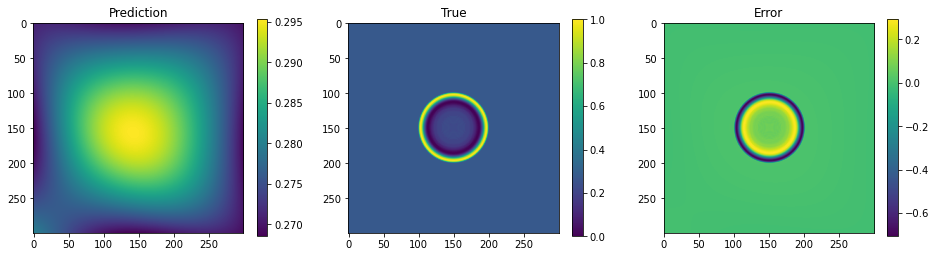

In [14]:
plots(df_start)

In [15]:
PATH = model_name

In [16]:
# Save model to reuse it later
torch.save(model_trained_start.state_dict(), PATH)